In [13]:
ALGORITHM = 'KNN'
ALGORITHM_DETAIL = 'basic'
VERSION = '01'

RANDOM_STATE = 101

In [14]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

import functions_20221011a
from functions_20221011a import set_csv_directory

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

debug_mode = False

In [15]:
set_csv_directory('final_split')

#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [16]:
filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = 'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221011a.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                            folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=TRAINING_SIZE, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=TRAINING_SIZE, random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [17]:
df = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

df = functions_20221011a.pre_tidy_dataset(df)
df = df[columns]

df.to_csv(df_pathname_tidy)
print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

(54067, 7)
Index(['14520525', '27953107', '33593487', '35271294', '35429088', '44749111',
       '46204665', '49020666', '49036279', '49303873',
       ...
       '126173423', '126173600', '126175973', '126178769', '126179018',
       '126179672', '126180107', '126180704', '126180962', '126181118'],
      dtype='object', length=54067)


In [18]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [19]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1802
bathrooms             3498
nearestStation           0
tenure.tenureType     3654
dtype: int64

In [20]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 54067 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               54067 non-null  int64  
 1   location.latitude   54067 non-null  object 
 2   location.longitude  54067 non-null  float64
 3   bedrooms            52265 non-null  float64
 4   bathrooms           50569 non-null  float64
 5   nearestStation      54067 non-null  float64
 6   tenure.tenureType   50413 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.3+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,54067.000000,54067.000000,52265.000000,50569.000000,54067.000000
mean,416448.380528,-0.106239,11.360145,1.181534,0.442075
std,113505.624206,0.718769,2143.329175,0.413244,1.049040
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,325000.000000,-0.212965,1.000000,1.000000,0.221778
50%,425000.000000,-0.105220,2.000000,1.000000,0.361208
75%,500000.000000,-0.012998,2.000000,1.000000,0.553963
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [21]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 54067 ==> 49016


,count,mean,std,min,25%,50%,75%,max
Price,49016.0,421205.709136,110831.099938,100000.000000,339950.000000,425000.000000,500000.000000,600000.000000
location.latitude,49016.0,51.496432,0.077345,51.298317,51.438138,51.499720,51.555650,51.683185
location.longitude,49016.0,-0.114267,0.156269,-0.498315,-0.211373,-0.103357,-0.011796,0.279726
bedrooms,49016.0,1.981394,0.824532,1.000000,1.000000,2.000000,2.000000,7.000000
bathrooms,49016.0,1.186674,0.413086,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,49016.0,0.437429,0.353326,0.000000,0.224506,0.365045,0.556585,16.168861


In [22]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2874
dtype: int64

In [23]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

49016 ==> 46142


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000,46142.000000
mean,421282.384335,51.496075,-0.114033,1.979953,1.185753,0.437174
std,110858.107656,0.077508,0.155650,0.823314,0.411915,0.352397
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,339950.000000,51.437568,-0.211290,1.000000,1.000000,0.225159
50%,425000.000000,51.498427,-0.103070,2.000000,1.000000,0.365437
75%,500000.000000,51.555687,-0.012061,2.000000,1.000000,0.556509
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [24]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(41527, 9) (4615, 9) (41527, 1) (4615, 1) (41527, 1) (4615, 1) (41527, 1) (4615, 1)


In [25]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [26]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(X_train, y_train)

from time import time

timings = []

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

t0 = time()
model.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.08203601837158203, 0.10175490379333496, 0.11255049705505371, 0.12037873268127441, 0.13079380989074707]
0.10950279235839844


In [27]:
y_pred = model.predict(X_test)

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy: ', R2)
print('Mean Absolute Error Accuracy: ', MAE)
print('Mean Squared Error Accuracy: ', MSE)
print('Root Mean Squared Error: ', RMSE)

----------KNN----------
R square Accuracy:  0.5468906572891401
Mean Absolute Error Accuracy:  55623.65893824485
Mean Squared Error Accuracy:  5345846038.636742
Root Mean Squared Error:  73115.2927822678


In [29]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [30]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
123574331,250000,223000.0,27000.0,10.8,12.107623
89830105,250000,389999.0,139999.0,55.9996,35.897272
125141039,450000,418000.0,32000.0,7.111111,7.655502
118720436,535000,497000.0,38000.0,7.102804,7.645875
119803049,550000,505000.0,45000.0,8.181818,8.910891
...,...,...,...,...,...
125933711,325000,290000.0,35000.0,10.769231,12.068966
119566388,350000,418990.0,68990.0,19.711429,16.465787
125380766,575000,549000.0,26000.0,4.521739,4.735883


In [31]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True)
# 85514838
# 115470422

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
123574331,250000,223000.0,27000.0,10.8,12.107623,250000,51.564130,0.139653,1.0,1.0,0.519832,LEASEHOLD
89830105,250000,389999.0,139999.0,55.9996,35.897272,250000,51.522010,-0.020800,2.0,1.0,0.105742,LEASEHOLD
125141039,450000,418000.0,32000.0,7.111111,7.655502,450000,51.532019,0.192593,3.0,1.0,1.034847,FREEHOLD
118720436,535000,497000.0,38000.0,7.102804,7.645875,535000,51.557649,0.240515,3.0,1.0,0.219035,FREEHOLD
119803049,550000,505000.0,45000.0,8.181818,8.910891,550000,51.440090,0.020980,3.0,2.0,0.661443,FREEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...
125933711,325000,290000.0,35000.0,10.769231,12.068966,325000,51.541700,0.022430,2.0,1.0,0.536541,LEASEHOLD
119566388,350000,418990.0,68990.0,19.711429,16.465787,350000,51.514730,-0.231508,3.0,1.0,0.357201,LEASEHOLD
125380766,575000,549000.0,26000.0,4.521739,4.735883,575000,51.593908,-0.273908,3.0,1.0,0.536167,FREEHOLD
118744790,400000,332400.0,67600.0,16.9,20.336943,400000,51.584390,0.027960,2.0,1.0,0.373618,LEASEHOLD


In [32]:
score = model.score(X_test, y_test)
score

0.5468906572891401

In [33]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.5468906572891401

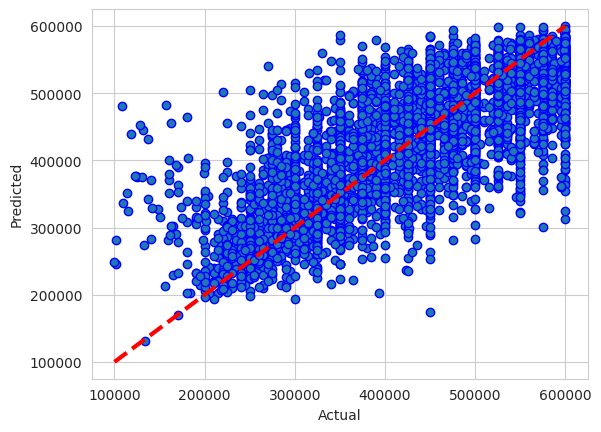

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, model.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [36]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy: ': R2,
    'Mean Absolute Error Accuracy: ': MAE,
    'Mean Squared Error Accuracy: ': MSE,
    'Root Mean Squared Error: ': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now())
}
import json

results_filename = '../../results/results.json'

with open(results_filename) as f:
    raw_audit = f.read()
results_json = json.loads(raw_audit)

results_json[f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()] = results

with open(results_filename, 'w') as file:
    file.write(json.dumps(results_json, indent=4))
